In [1]:
import os
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.interpolate import interp1d

# Libraries for plotting, reading data:
import seaborn as sns 
sns.set_style("ticks") # Set seaborn "ticks" style for better styled plots
from astropy.io import fits
from astropy.utils.data import download_file
# Library for some power-spectral density analysis:
from astropy.timeseries import LombScargle

# Corner (for posterior distribution plotting):
import corner
# Juliet (for transit fitting & model evaluation:)
import juliet

In [2]:
# Read in data and calibration files
data_files = sorted(glob.glob("LBT-HAT-P-19/*.fits"))
calibration_files = sorted(glob.glob("LBT-HAT-P-19/calibration/*.fits"))

In [3]:
# function to categorize the calibration files into lamp, flat, and bias
def categorize_calibration(cal_files):
    lamp_calibration = []
    flat_calibration = []
    bias_calibration = []
    
    for i in cal_files:
        data, header = fits.getdata(i, header=True)
        
        if header["MASKNAME"] == "ID582153":
            lamp_calibration.append(i)

        elif header["MASKNAME"] == "ID583213":
            flat_calibration.append(i)

        elif header["IMAGETYP"] == "BIAS":  # tested: if header["IMAGETYP"] == "BIAS" then ["MASKNAME"] == "SIEVEMASK"
            bias_calibration.append(i)

    return lamp_calibration, flat_calibration, bias_calibration

In [4]:
# function to categorize the lamp files by instrument
def categorize_lamp(lamp_files):
    lamp_m1b = []
    lamp_m2b = []
    lamp_m1r = []
    lamp_m2r = []
    
    for i in lamp_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            lamp_m1b.append(i)

        elif header["INSTRUME"] == "MODS2B":
            lamp_m2b.append(i)

        elif header["INSTRUME"] == "MODS1R":
            lamp_m1r.append(i)
            
        elif header["INSTRUME"] == "MODS2R":
            lamp_m2r.append(i)

    return lamp_m1b, lamp_m2b, lamp_m1r, lamp_m2r

In [5]:
# function to categorize the bias files by instrument and take the median of the frames
def categorize_bias_median(bias_files):
    bias_m1b = []
    bias_m2b = []
    bias_m1r = []
    bias_m2r = []
    
    for i in bias_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            bias_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            bias_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            bias_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            bias_m2r.append(data)

    ave_bias_m1b = np.median(bias_m1b, axis=0)
    ave_bias_m2b = np.median(bias_m2b, axis=0)
    ave_bias_m1r = np.median(bias_m1r, axis=0)
    ave_bias_m2r = np.median(bias_m2r, axis=0)
    
    return ave_bias_m1b, ave_bias_m2b, ave_bias_m1r, ave_bias_m2r

In [6]:
# function to categorize the flat files by instrument, subtract the master bias frame corresponding to the instrument
# and then take the median of the frames
def categorize_flat_median(flat_files, bias_m1b, bias_m2b, bias_m1r, bias_m2r):
    flat_m1b = []
    flat_m2b = []
    flat_m1r = []
    flat_m2r = []
    
    for i in flat_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            flat_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            flat_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            flat_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            flat_m2r.append(data)

    m1b_sub = flat_m1b-bias_m1b
    m2b_sub = flat_m2b-bias_m2b
    m1r_sub = flat_m1r-bias_m1r
    m2r_sub = flat_m2r-bias_m2r
       
    ave_flat_m1b = np.median(m1b_sub, axis=0)
    ave_flat_m2b = np.median(m2b_sub, axis=0)
    ave_flat_m1r = np.median(m1r_sub, axis=0)
    ave_flat_m2r = np.median(m2r_sub, axis=0)
    
    return ave_flat_m1b, ave_flat_m2b, ave_flat_m1r, ave_flat_m2r

In [7]:
# 1. create master bias frame (median of all bias frames)
# 2. subtract master bias frame from all data frames and all flat frames
# 3. create master flat frame as the median of bias-subtracted flat frames
# 4. divide the data frames by the master flat frame

def calibrate_data(data_files, calibration_files): # not currently using the data files yet, just setting up cal files
    lamp, flat, bias = categorize_calibration(calibration_files)
    bias_m1b, bias_m2b, bias_m1r, bias_m2r = categorize_bias_median(bias)
    flat_m1b, flat_m2b, flat_m1r, flat_m2r = categorize_flat_median(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    lamp_m1b, lamp_m2b, lamp_m1r, lamp_m2r = categorize_lamp(lamp)
    
    # will return a dictionary with the instrument attached to: the master bias, the master flat, 
    # and the list of lamps for that instrument (don't know what to do with the lamps yet)
    calibrate_dict = {
        "m1b":[bias_m1b, flat_m1b, lamp_m1b],
        "m2b":[bias_m2b, flat_m2b, lamp_m2b],
        "m1r":[bias_m1r, flat_m1r, lamp_m1r],
        "m2r":[bias_m2r, flat_m2r, lamp_m2r]
    }
    
    return(calibrate_dict)

In [58]:
def flat_errors_calc(flat_files, bias_m1b, bias_m2b, bias_m1r, bias_m2r): # finding the errors on the flat frames
    flat_m1b = []
    flat_m2b = []
    flat_m1r = []
    flat_m2r = []
    
    for i in flat_files:
        data, header = fits.getdata(i, header=True)
        
        if header["INSTRUME"] == "MODS1B":
            flat_m1b.append(data)

        elif header["INSTRUME"] == "MODS2B":
            flat_m2b.append(data)

        elif header["INSTRUME"] == "MODS1R":
            flat_m1r.append(data)
            
        elif header["INSTRUME"] == "MODS2R":
            flat_m2r.append(data)

    m1b_sub = flat_m1b-bias_m1b
    m2b_sub = flat_m2b-bias_m2b
    m1r_sub = flat_m1r-bias_m1r
    m2r_sub = flat_m2r-bias_m2r
    
    m1b_sub_norm = []
    m2b_sub_norm = []
    m1r_sub_norm = []
    m2r_sub_norm = []
    
    for i in range(len(m1b_sub)): # there is the same number of flat files for all the instruments
        m1b_norm = m1b_sub[i]/np.median(m1b_sub[i])
        m1b_sub_norm.append(m1b_norm)
        
        m2b_norm = m2b_sub[i]/np.median(m2b_sub[i])
        m2b_sub_norm.append(m1b_norm)
        
        m1r_norm = m1r_sub[i]/np.median(m1r_sub[i])
        m1r_sub_norm.append(m1b_norm)
        
        m2r_norm = m2r_sub[i]/np.median(m2r_sub[i])
        m2r_sub_norm.append(m1b_norm)
        
        
    m1b_flat_norm_med = np.median(m1b_sub_norm, axis=0) # finding the normalized median
    m2b_flat_norm_med = np.median(m2b_sub_norm, axis=0)
    m1r_flat_norm_med = np.median(m1r_sub_norm, axis=0)
    m2r_flat_norm_med = np.median(m2r_sub_norm, axis=0)
    
    m1b_flat_error = np.sqrt(np.var(m1b_sub_norm, axis=0)) # finding the STD per pixel: sqrt(var)
    m2b_flat_error = np.sqrt(np.var(m2b_sub_norm, axis=0))
    m1r_flat_error = np.sqrt(np.var(m1r_sub_norm, axis=0))
    m2r_flat_error = np.sqrt(np.var(m2r_sub_norm, axis=0))
    
    norm_median = [m1b_flat_norm_med, m2b_flat_norm_med, m1r_flat_norm_med, m2r_flat_norm_med]
    errors = [m1b_flat_error, m2b_flat_error, m1r_flat_error, m2r_flat_error]
    
    
    return(norm_median, errors)

In [70]:
def calibrate_data_errors(data_files, calibration_files): # finding the error on the flat field data
    lamp, flat, bias = categorize_calibration(calibration_files)
    bias_m1b, bias_m2b, bias_m1r, bias_m2r = categorize_bias_median(bias)
    flat_m1b, flat_m2b, flat_m1r, flat_m2r = categorize_flat_median(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    norm_med, errors = flat_errors_calc(flat, bias_m1b, bias_m2b, bias_m1r, bias_m2r)
    
    return(norm_med, errors) # returns normalized, bias subtracted median flat frames and associated errors
    

In [ ]:
norm_med, flat_error = calibrate_data_errors(data_files, calibration_files)

<ErrorbarContainer object of 3 artists>

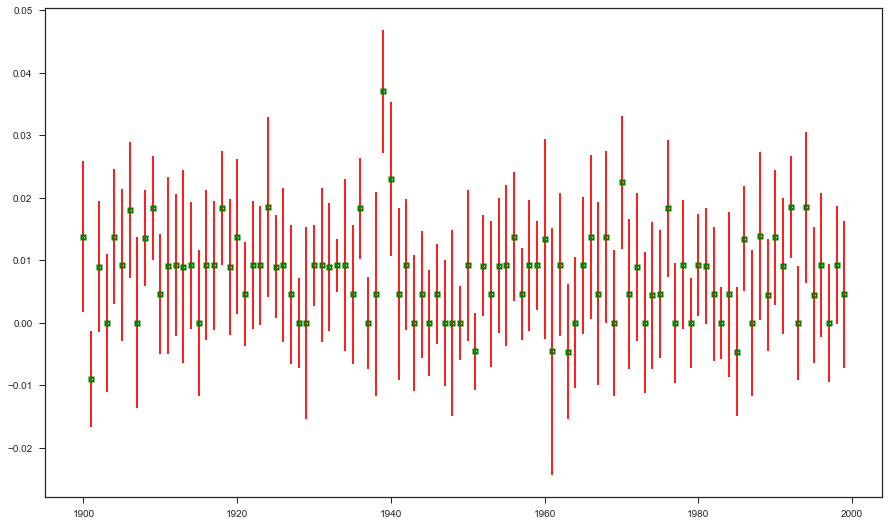

In [69]:
xs = range(0, len(norm_med[0][0]), 1)

plt.figure(figsize=(15,9))
plt.errorbar(xs[1900:2000],norm_med[0][0][1900:2000], yerr = flat_error[0][0][1900:2000], linestyle="None", markersize=1, ecolor = "red", marker='s', mfc='red',
         mec='green', ms=5, mew=5)

In [52]:
print(len(test_error))

1544


In [ ]:
norm_med